In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import pylab as pl
import scipy.stats as st
import seaborn as sns
import pandas as pd
import detection as dtc
import fitting
import emission
from constants import *
import cross_sections as cs
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import gamma
from scipy.integrate import simps, simpson
from tqdm import tqdm
import os
from sklearn.metrics import r2_score
from random import choices

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [43]:
E = np.linspace(5, 100, 500) # Neutrino detection energy
detector = 'DUNE'
distance = 10 # kpc
targets = 6.03e32
EOS = 'LS220-27.0'
hierarchy = 'normal'

In [7]:
L_true = np.sum(params[EOS][-3:])

In [8]:
detection_nue = dtc.detection_spectra(E, EOS, 'nu_e', detector, hierarchy, distance, get_directions = False)
detection_nubare = dtc.detection_spectra(E, EOS, 'nubar_e', detector, hierarchy, distance, get_directions = False)
detection_nux = dtc.detection_spectra(E, EOS, 'nu_x', detector, hierarchy, distance, get_directions = False)

In [9]:
detection = detection_nue + detection_nubare + detection_nux

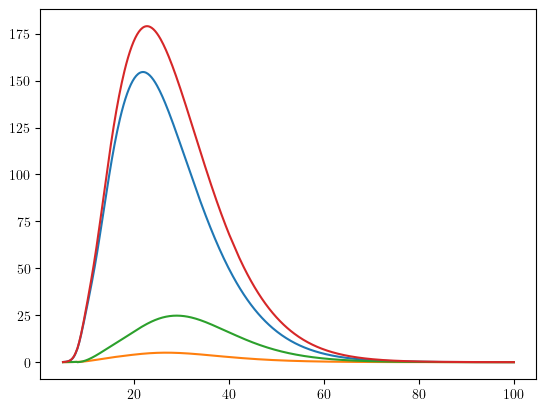

In [10]:
plt.plot(E, detection_nue)
plt.plot(E, detection_nubare)
plt.plot(E, detection_nux)
plt.plot(E, detection)
plt.show()

In [11]:
npoints = 500
Enu_list = E.copy()
Edec = {}
for i in range(29):
    Edec[i] = np.linspace(3.5*i, 3.5*(i+1), npoints)

In [12]:
len(Edec)

29

In [13]:
d=[]
ddec = {}
for i in range(len(Edec)):
    ddec[i] = []

In [14]:
for i in tqdm(range(len(Enu_list))):
    E_nu = Enu_list[i]
    dd = 0
    for j in range(len(Edec)):
        dd += simpson(detection[i]*dtc.resolution_detector(Edec[j],E_nu,detector),Edec[j])
        ddec[j].append(dd)
    d.append(dd)

100%|██████████| 500/500 [00:02<00:00, 223.78it/s]


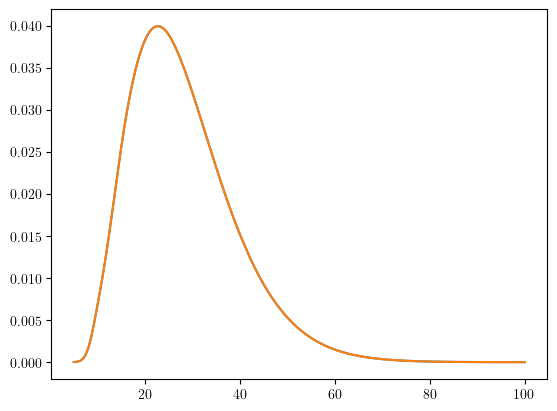

In [15]:
# for i in range(20):
#     plt.plot(Edec[i], ddec[i], label=fr'$n_{i}(E_\nu)$')
plt.plot(E, detection/simps(detection, E))
plt.plot(Enu_list, d/simps(d, Enu_list), label=r'$n(E_\nu)$')
plt.show()

In [16]:
enubin = []
for i in range(29):
    enubin.append([3.5*i, 3.5*(i+1)])
    
enubin = np.array(enubin).flatten()

In [17]:
enubin

array([  0. ,   3.5,   3.5,   7. ,   7. ,  10.5,  10.5,  14. ,  14. ,
        17.5,  17.5,  21. ,  21. ,  24.5,  24.5,  28. ,  28. ,  31.5,
        31.5,  35. ,  35. ,  38.5,  38.5,  42. ,  42. ,  45.5,  45.5,
        49. ,  49. ,  52.5,  52.5,  56. ,  56. ,  59.5,  59.5,  63. ,
        63. ,  66.5,  66.5,  70. ,  70. ,  73.5,  73.5,  77. ,  77. ,
        80.5,  80.5,  84. ,  84. ,  87.5,  87.5,  91. ,  91. ,  94.5,
        94.5,  98. ,  98. , 101.5])

In [18]:
bins=np.array([[simpson(ddec[i],Enu_list), simpson(ddec[i],Enu_list)] for i in range(len(Edec))])

In [19]:
bins = np.concatenate((bins[:1,:], bins[1:,:]-bins[:-1,:]))

In [20]:
bins = bins.flatten()

In [21]:
values = bins[range(0, len(bins), 2)]

In [22]:
positions = (enubin[1:] + enubin[:-1])[range(0, len(bins), 2)]/2

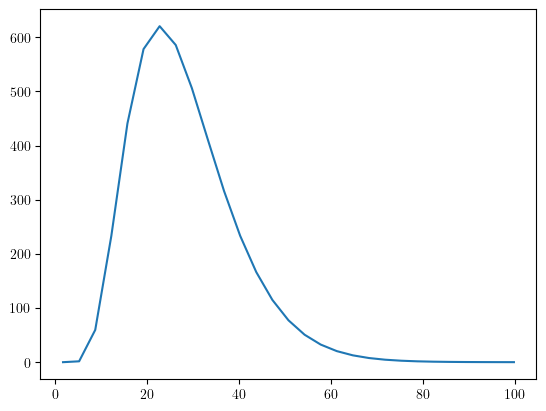

In [23]:
plt.plot(positions, values)
plt.show()

In [24]:
f = fitting.fitting_spectra

In [25]:
def fitting_spectra(x, alpha, E_mean):
    """
    Shape of the detection spectrum
    """
################################ SUPER-K
#     channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
#                     'numubar_e','nc_nue_O16','nc_nuebar_O16']
#     xs_data = cs.snowglobes(channels)

#     # All these cross sections are in units of 10⁻³⁸ cm²/MeV
#     cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
#     cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
#     cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
#     cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
#     cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
#     cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
#     cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
#     cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
#     cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
#     cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
#     # Total cross section
#     total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nuebar_O16(x)*x*1e-38
#     # Detector efficiency
#     eff = np.where(x<4.5,0,0.9) #efficiency_sigmoid(x, 0.918, 1.2127, 3)

################################ DUNE
    channels = ['ibd','nue_e','nuebar_e','nue_Ar40','nuebar_Ar40','numu_e',
                    'numubar_e','nc_nue_Ar40','nc_nuebar_Ar40','nc_numu_Ar40',
                    'nc_numubar_Ar40']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
    cs_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
    cs_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
    cs_nc_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
    cs_nc_nux_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[9][2]/1e3, fill_value='extrapolate')
    cs_nc_nuxbar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[10][5]/1e3, fill_value='extrapolate')
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_Ar40(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_nuebar_Ar40(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nue_Ar40(x)*x*1e-38 + cs_nc_nuebar_Ar40(x)*x*1e-38 + cs_nc_nux_Ar40(x)*x*1e-38 + cs_nc_nuxbar_Ar40(x)*x*1e-38
    # Detector efficiency
    eff = dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)
    
################################# JUNO
#     channels = ['ibd','nue_e','nuebar_e','nue_C12','nuebar_C12','numu_e',
#                     'numubar_e','nc_nue_C12','nc_nuebar_C12','nc_numu_C12',
#                     'nc_numubar_C12']
#     xs_data = cs.snowglobes(channels)

#     # All these cross sections are in units of 10⁻³⁸ cm²/MeV
#     cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value = 'extrapolate')
#     cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value = 'extrapolate')
#     cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value = 'extrapolate')
#     cs_nue_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value = 'extrapolate')
#     cs_nuebar_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value = 'extrapolate')
#     cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value = 'extrapolate')
#     cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value = 'extrapolate')
#     cs_nc_nue_C12 = interp1d(1e3*(10**(xs_data[7][0])), xs_data[7][1]/1e3, fill_value = 'extrapolate')
#     cs_nc_nuebar_C12 = interp1d(1e3*(10**(xs_data[8][0])), xs_data[8][4]/1e3, fill_value = 'extrapolate')
#     cs_nc_nux_C12 = interp1d(1e3*(10**(xs_data[9][0])), xs_data[9][2]/1e3, fill_value = 'extrapolate')
#     cs_nc_nuxbar_C12 = interp1d(1e3*(10**(xs_data[10][0])), xs_data[10][5]/1e3, fill_value = 'extrapolate')
#     # Number of target particles
#     """"
#     Fengpeng, A., Guangpeng, A. N., Qi, A. N., Antonelli, V., Baussan, E.,
#     Beacom, J., ... & Sinev, V. (2016). Neutrino physics with JUNO.
#     """
#     # Total cross section
#     total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_C12(x)*x*1e-38 + cs_nc_nue_C12(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_C12(x)*x*1e-38 + cs_nc_nuebar_C12(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_C12(x)*x*1e-38 + cs_nc_nuxbar_C12(x)*x*1e-38
#     eff = np.where(x<0.3,0,1) #efficiency_sigmoid(x, 0.918, 1.2127, 3)
    # Combined spectrum
    spectrum = fitting.spectrum_shape(x, alpha, E_mean)
    all = spectrum*total_cross*eff
    # Normalization
    A = simps(all, x)
    return all/A

def fitting_spectra_not_norm(x, alpha, E_mean):
    """
    Shape of the detection spectrum
    """
################################ SUPER-K
#     channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
#                     'numubar_e','nc_nue_O16','nc_nuebar_O16']
#     xs_data = cs.snowglobes(channels)

#     # All these cross sections are in units of 10⁻³⁸ cm²/MeV
#     cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
#     cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
#     cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
#     cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
#     cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
#     cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
#     cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
#     cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
#     cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
#     cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
#     # Total cross section
#     total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nuebar_O16(x)*x*1e-38
#     # Detector efficiency
#     eff = np.where(x<4.5,0,0.9) #efficiency_sigmoid(x, 0.918, 1.2127, 3)

################################ DUNE
    channels = ['ibd','nue_e','nuebar_e','nue_Ar40','nuebar_Ar40','numu_e',
                    'numubar_e','nc_nue_Ar40','nc_nuebar_Ar40','nc_numu_Ar40',
                    'nc_numubar_Ar40']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
    cs_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
    cs_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
    cs_nc_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
    cs_nc_nux_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[9][2]/1e3, fill_value='extrapolate')
    cs_nc_nuxbar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[10][5]/1e3, fill_value='extrapolate')
    # Total cross section
    total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_Ar40(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_nuebar_Ar40(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nue_Ar40(x)*x*1e-38 + cs_nc_nuebar_Ar40(x)*x*1e-38 + cs_nc_nux_Ar40(x)*x*1e-38 + cs_nc_nuxbar_Ar40(x)*x*1e-38
    # Detector efficiency
    eff = dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)
    
################################# JUNO
#     channels = ['ibd','nue_e','nuebar_e','nue_C12','nuebar_C12','numu_e',
#                     'numubar_e','nc_nue_C12','nc_nuebar_C12','nc_numu_C12',
#                     'nc_numubar_C12']
#     xs_data = cs.snowglobes(channels)

#     # All these cross sections are in units of 10⁻³⁸ cm²/MeV
#     cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value = 'extrapolate')
#     cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value = 'extrapolate')
#     cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value = 'extrapolate')
#     cs_nue_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value = 'extrapolate')
#     cs_nuebar_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value = 'extrapolate')
#     cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value = 'extrapolate')
#     cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value = 'extrapolate')
#     cs_nc_nue_C12 = interp1d(1e3*(10**(xs_data[7][0])), xs_data[7][1]/1e3, fill_value = 'extrapolate')
#     cs_nc_nuebar_C12 = interp1d(1e3*(10**(xs_data[8][0])), xs_data[8][4]/1e3, fill_value = 'extrapolate')
#     cs_nc_nux_C12 = interp1d(1e3*(10**(xs_data[9][0])), xs_data[9][2]/1e3, fill_value = 'extrapolate')
#     cs_nc_nuxbar_C12 = interp1d(1e3*(10**(xs_data[10][0])), xs_data[10][5]/1e3, fill_value = 'extrapolate')
#     # Number of target particles
#     """"
#     Fengpeng, A., Guangpeng, A. N., Qi, A. N., Antonelli, V., Baussan, E.,
#     Beacom, J., ... & Sinev, V. (2016). Neutrino physics with JUNO.
#     """
#     # Total cross section
#     total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_C12(x)*x*1e-38 + cs_nc_nue_C12(x)*x*1e-38 + cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_C12(x)*x*1e-38 + cs_nc_nuebar_C12(x)*x*1e-38 + cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_C12(x)*x*1e-38 + cs_nc_nuxbar_C12(x)*x*1e-38
#     eff = np.where(x<0.3,0,1) #efficiency_sigmoid(x, 0.918, 1.2127, 3)
    # Combined spectrum
    spectrum = fitting.spectrum_shape(x, alpha, E_mean)
    all = spectrum*total_cross*eff
    # Normalization
    return all

In [26]:
c, cov = curve_fit(fitting_spectra, E, detection/simps(detection, E), bounds = ([0,0],[5, 20]),
                  p0 = (2, 12))

In [27]:
print(f'True pinch parameter: {c[0]:.3f} +/- {np.sqrt(cov[0,0]):.3f} \n True mean energy: {c[1]:.3f} +/- {np.sqrt(cov[1,1]):.3f}')

True pinch parameter: 1.778 +/- 0.002 
 True mean energy: 12.667 +/- 0.006


In [28]:
parameters = {}
parameters[f'True {hierarchy}'] = {}
parameters[f'True {hierarchy}']['Alpha_best'] = c[0]
parameters[f'True {hierarchy}']['Alpha_std'] = np.sqrt(cov[0,0])
parameters[f'True {hierarchy}']['E_mean_best'] = c[1]
parameters[f'True {hierarchy}']['E_mean_std'] = np.sqrt(cov[1,1])

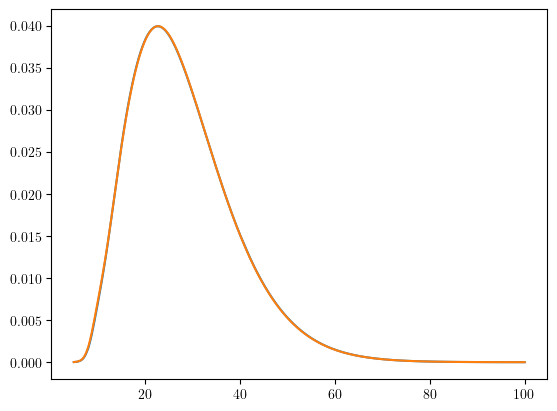

In [29]:
plt.plot(E, detection/simps(detection, E))
plt.plot(E, fitting_spectra(E, *c))
plt.show()

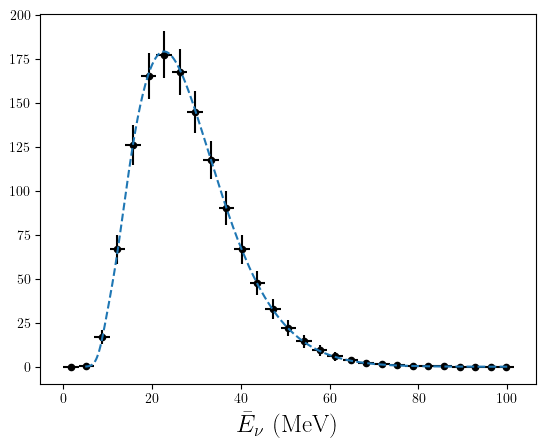

In [30]:
plt.figure()
# plt.plot(enubin,bin, label=r'$N_i$')
# plt.plot(E, detection, ls = '--')
plt.scatter(positions, values/3.5, s = 20, color = 'black')
plt.errorbar(positions, values/3.5, yerr = np.sqrt(values/3.5), xerr = 1.75,
            fmt = 'none', color = 'black')
# plt.xlim(2,35)
plt.plot(E, simps(d, Enu_list)*fitting_spectra(E, *c), ls = '--')
plt.xlabel(r'$\bar{E}_\nu$ (MeV)',fontsize=18)
# plt.legend(fontsize=11)
# plt.ylim(0, 410)
plt.show()

In [31]:
ref = dtc.energy_sampler(E, EOS, detector, hierarchy, distance,
                         theta_detec = 0, get_directions = False)


Number of expected neutrinos by flavor at 10 kpc (DUNE)

electron neutrinos: 3667
electron antineutrinos: 137
mu/tau (anti)neutrinos: 675


In [38]:
3667+137+675

4479

In [32]:
len(ref['Energy_Total'])

4450

In [33]:
# y, bins = np.histogram(ref['Energy_Total'], bins = [7*i for i in range(16)], density = True) # Super/Hyper-K
y, bins = np.histogram(ref['Energy_Total'], bins = [3.5*i for i in range(29)], density = True)

In [34]:
x = (bins[:-1] + bins[1:])/2

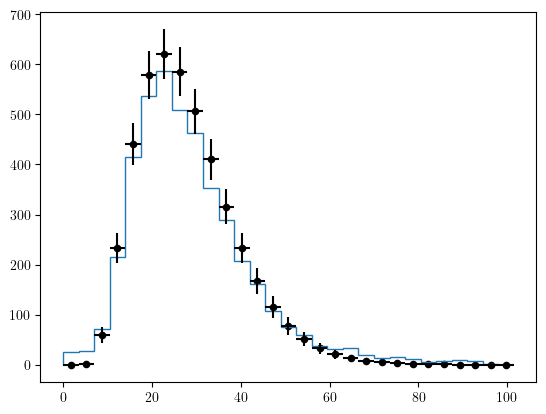

In [35]:
# plt.plot(x, y)
plt.hist(ref['Energy_Total'], bins = [3.5*i for i in range(29)], histtype = 'step')
plt.scatter(positions, values, s = 20, color = 'black')
plt.errorbar(positions, values, yerr = 2*np.sqrt(values), xerr = 1.75,
            fmt = 'none', color = 'black')
plt.show()

In [36]:
c, cov = curve_fit(fitting_spectra, x, y, bounds = ([0,0],[5, 20]))

In [37]:
print(f'Fitted pinch parameter: {c[0]:.3f} +/- {np.sqrt(cov[0,0]):.3f} \n Fitted mean energy: {c[1]:.3f} +/- {np.sqrt(cov[1,1]):.3f}')

Fitted pinch parameter: 1.031 +/- 0.155 
 Fitted mean energy: 10.666 +/- 0.500


In [413]:
parameters[f'Fitted_delta_0 {hierarchy}'] = {}
parameters[f'Fitted_delta_0 {hierarchy}']['Alpha_best'] = c[0]
parameters[f'Fitted_delta_0 {hierarchy}']['Alpha_std'] = np.sqrt(cov[0,0])
parameters[f'Fitted_delta_0 {hierarchy}']['E_mean_best'] = c[1]
parameters[f'Fitted_delta_0 {hierarchy}']['E_mean_std'] = np.sqrt(cov[1,1])

In [39]:
curves = []

E = np.linspace(0, 100, 10000)

for i in tqdm(range(100)):
    a = np.random.normal(c[0], np.sqrt(cov[0,0]))
    b = np.random.normal(c[1], np.sqrt(cov[1,1]))
    
    curves.append(fitting_spectra(E, a, b))
    
curves = np.array(curves)

100%|██████████| 100/100 [00:03<00:00, 32.94it/s]


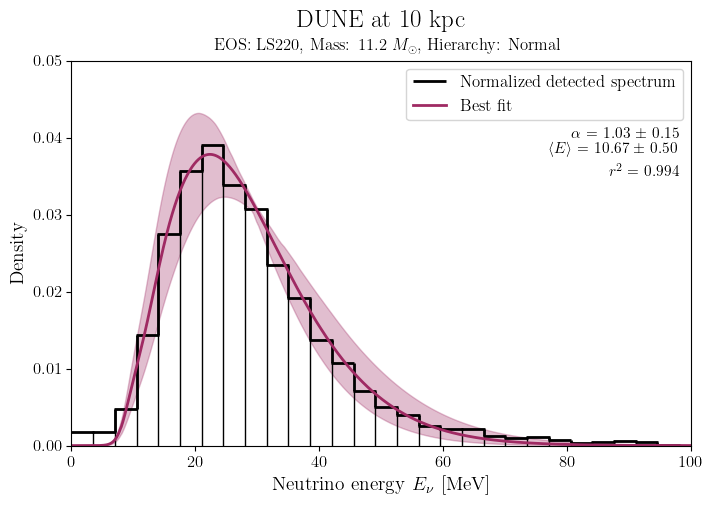

In [40]:
E = np.linspace(0, 100, 10000)

fig, ax = plt.subplots(figsize = (8,5))
# plt.plot(x, y, lw = 2, color = 'black')
plt.hlines(y, bins[:-1]-0.15, bins[1:]+0.15, lw = 2, color = 'black', label = 'Normalized detected spectrum')
plt.vlines(bins[1:-1], y[:-1], y[1:], lw = 2, color = 'black')
plt.vlines(bins[1:-1], 0, y[1:], lw = 1, color = 'black')
plt.plot(E, fitting_spectra(E, *c), color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
# plt.plot(x, np.mean(curves, axis = 0), color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
plt.fill_between(E, np.percentile(curves, 2.5, axis = 0),
                 np.percentile(curves, 97.5, axis = 0),
                 color = sns.color_palette('inferno')[2], alpha = 0.3)
plt.xlim(0, 100)
plt.ylim(0, 0.05)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(r'Neutrino energy $E_\nu$ [MeV]', fontsize = 14)
plt.ylabel(r'Density', fontsize = 14)
plt.title(r'DUNE at 10 kpc', fontsize = 18, pad = 24)
fig.text(0.52, 0.9, r'EOS: LS220, Mass: 11.2 $M_{\odot}$, Hierarchy: Normal', fontsize = 12, ha = 'center')
plt.legend(loc = 'upper right', fontsize = 12)
plt.text(98, 0.038, fr'$\alpha$ = {c[0]:.2f} $\pm$ {np.sqrt(cov[0,0]):.2f}'
         '\n'
         fr'$\left \langle E \right \rangle$ = {c[1]:.2f} $\pm$ {np.sqrt(cov[1,1]):.2f}',
         fontsize = 11, ha = 'right')
plt.text(98, 0.035, f'$r^2 = $ {r2_score(y, fitting_spectra(x, *c)):.3f}', fontsize = 11,
         ha = 'right')
fig.patch.set_alpha(0.3)
for ax in fig.axes:
    ax.patch.set_alpha(0.7)
    
# plt.savefig(f'Plots/{detector}_detection_spectrum_fit_least-squares_{hierarchy}_10kpc_perfect_resolution_{EOS}.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'Plots/{detector}_detection_spectrum_fit_least-squares_{hierarchy}_10kpc_perfect_resolution_{EOS}.svg',
#             dpi = 300, bbox_inches = 'tight')
plt.show()

In [41]:
len(ref['Energy_Total'])

4450

In [44]:
simps(detection, E)

4478.891952599387

In [53]:
simps((L_true*targets*6.2415e5*0.385/(4*np.pi*(10*3.086e21)**2))*fitting_spectra_not_norm(E, *c), E)

4445.464824262291

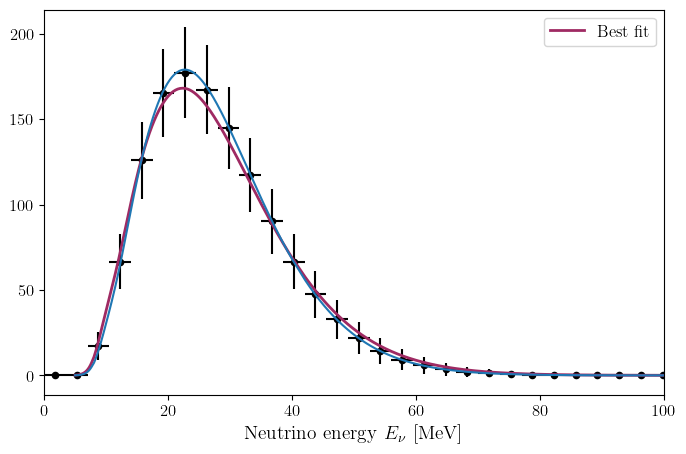

In [54]:
#E = np.linspace(0, 100, 10000)

fig, ax = plt.subplots(figsize = (8,5))
# plt.plot(x, y, lw = 2, color = 'black')
# plt.hist(ref['Energy_Total'], bins = [3.5*i for i in range(29)], histtype = 'step', lw = 2, color = 'black', label = 'Detected spectrum')
plt.scatter(positions, values/3.5, s = 20, color = 'black')
plt.errorbar(positions, values/3.5, yerr = 2*np.sqrt(values/3.5), xerr = 1.75,
            fmt = 'none', color = 'black')
plt.plot(E, (L_true*targets*6.2415e5*0.385/(4*np.pi*(10*3.086e21)**2))*fitting_spectra_not_norm(E, *c),
         color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
plt.plot(E, detection)
# plt.plot(x, np.mean(curves, axis = 0), color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
# plt.fill_between(E, np.percentile(curves, 2.5, axis = 0),
#                  np.percentile(curves, 97.5, axis = 0),
#                  color = sns.color_palette('inferno')[2], alpha = 0.3)
plt.xlim(0, 100)
# plt.ylim(0, 0.05)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(r'Neutrino energy $E_\nu$ [MeV]', fontsize = 14)
# plt.ylabel(r'Density', fontsize = 14)
# plt.title(r'DUNE at 10 kpc', fontsize = 18, pad = 24)
# fig.text(0.52, 0.9, r'EOS: LS220, Mass: 27 $M_{\odot}$, Hierarchy: Normal', fontsize = 12, ha = 'center')
plt.legend(loc = 'upper right', fontsize = 12)
# plt.text(98, 0.038, fr'$\alpha$ = {c[0]:.2f} $\pm$ {np.sqrt(cov[0,0]):.2f}'
#          '\n'
#          fr'$\left \langle E \right \rangle$ = {c[1]:.2f} $\pm$ {np.sqrt(cov[1,1]):.2f}',
#          fontsize = 11, ha = 'right')
# plt.text(98, 0.035, f'$r^2 = $ {r2_score(y, fitting_spectra(x, *c)):.3f}', fontsize = 11,
#          ha = 'right')
fig.patch.set_alpha(0.3)
for ax in fig.axes:
    ax.patch.set_alpha(0.7)
    
# plt.savefig(f'Plots/{detector}_detection_spectrum_fit_least-squares_{hierarchy}_10kpc_perfect_resolution.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'Plots/{detector}_detection_spectrum_fit_least-squares_{hierarchy}_10kpc_perfect_resolution.svg',
#             dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
plt.scatter([0,1], [parameters[f'True {hierarchy}']['Alpha_best'], parameters[f'Fitted_delta_0 {hierarchy}']['Alpha_best']])
plt.errorbar([0,1], [parameters[f'True {hierarchy}']['Alpha_best'], parameters[f'Fitted_delta_0 {hierarchy}']['Alpha_best']],
              yerr = [parameters[f'True {hierarchy}']['Alpha_std'], parameters[f'Fitted_delta_0 {hierarchy}']['Alpha_std']],
              fmt = 'none', capsize = 5)
plt.ylim(1, 2.5)
plt.show()

In [55]:
def spectrum_shape(x, alpha, E_mean):
    """
    Overral shape of the emission spectrum
    """
    A = ((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    f_nu = A*(x**alpha)*np.exp(-(alpha + 1)*x/E_mean)
    return f_nu

In [56]:
channels = ['ibd','nue_e','nuebar_e','nue_Ar40','nuebar_Ar40','numu_e',
            'numubar_e','nc_nue_Ar40','nc_nuebar_Ar40','nc_numu_Ar40',
            'nc_numubar_Ar40']
xs_data = cs.snowglobes(channels)

# All these cross sections are in units of 10⁻³⁸ cm²/MeV
cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
cs_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
cs_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
cs_nc_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
cs_nc_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
cs_nc_nux_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[9][2]/1e3, fill_value='extrapolate')
cs_nc_nuxbar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[10][5]/1e3, fill_value='extrapolate')
# Total cross section
nue_cross = cs_nue_e(x)*x*1e-38 + cs_nue_Ar40(x)*x*1e-38 + cs_nc_nue_Ar40(x)*x*1e-38
nubare_cross = cs_nuebar_e(x)*x*1e-38 + cs_nuebar_Ar40(x)*x*1e-38 + cs_nc_nuebar_Ar40(x)*x*1e-38
nux_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_Ar40(x)*x*1e-38 + cs_nc_nuxbar_Ar40(x)*x*1e-38
total_cross = nue_cross + nubare_cross + nux_cross

In [57]:
def R_th(M):
    M_sol = 1.989e30
    c = 2.98e8
    G = 6.67e-11
    return 2.9*M*M_sol*G/c**2

def R_sph(M):
    M_sol = 1.989e30
    return 10.4*((1000/716)**(2/3))*((M*M_sol/M_sol)**(1/3))

100%|██████████| 50000/50000 [00:00<00:00, 126474.95it/s]


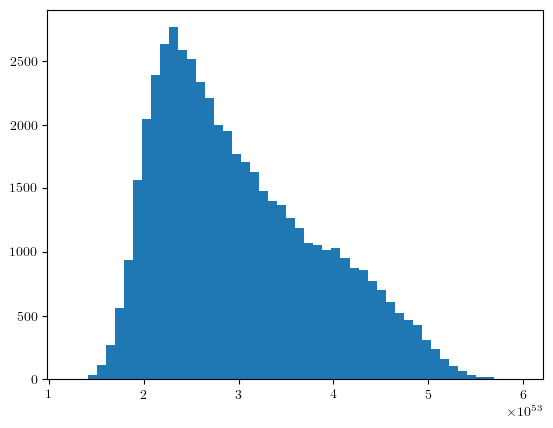

In [256]:
luminosities = []

for j in tqdm(range(50000)):
    # Sampling neutron star mass
    m_ns = np.random.normal(1.33, 0.09)
    # Setting the radius
    radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
    # Calculating total luminosity
    L = 3.6e53*((m_ns/1.5)**2)*(10/radius)#*0.346#*6.2415e5
    luminosities.append(L)

luminosities = np.array(luminosities)

plt.hist(luminosities, bins = 50)
plt.show()

In [58]:
N_T = len(ref['Energy_Total'])

In [63]:
distance_large_uniform = []
distance_tight_uniform = []
distance_true = []

for j in tqdm(range(50000)):
    # Sampling neutron star mass
    # m_ns = np.random.normal(1.33, 0.09)
    # Setting the radius
    # radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
    # Calculating total luminosity
    # L = 3.6e53*((m_ns/1.5)**2)*(10/radius)*6.2415e5
    # L = L_true*6.2415e5
    L_large = np.random.uniform(6e52, 3e53)*6.2415e5
    L_tight = np.random.normal(1.5e53, 3e52)*6.2415e5
    # L = np.random.normal(L_true, 0.5e52)*6.2415e5
    L_eff_large = L_large*0.38
    L_eff_tight = L_tight*0.38
    L_eff_true = L_true*6.2415e5*0.38
    # Calculating distance squared
    a = np.random.normal(c[0], np.sqrt(cov[0,0]))
    # a = np.random.normal(1.778, 0.002)
    b = np.random.normal(c[1], np.sqrt(cov[1,1]))
    # b = np.random.normal(12.667, 0.006)
    D_square_large = (L_eff_large/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)*total_cross, x)
    distance_large_uniform.append(np.sqrt(D_square_large)*3.2408e-22)
    D_square_tight = (L_eff_tight/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)*total_cross, x)
    distance_tight_uniform.append(np.sqrt(D_square_tight)*3.2408e-22)
    D_square_true = (L_eff_true/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)*total_cross, x)
    distance_true.append(np.sqrt(D_square_true)*3.2408e-22)

100%|██████████| 50000/50000 [00:22<00:00, 2257.63it/s]


In [64]:
np.nanpercentile(distance_tight_uniform, 25), np.nanpercentile(distance_tight_uniform, 75)

(8.76577065730525, 10.319982435484931)

In [65]:
np.percentile(distance_large_uniform, 25), np.percentile(distance_large_uniform, 75)

(8.497382135846173, 12.072244014123877)

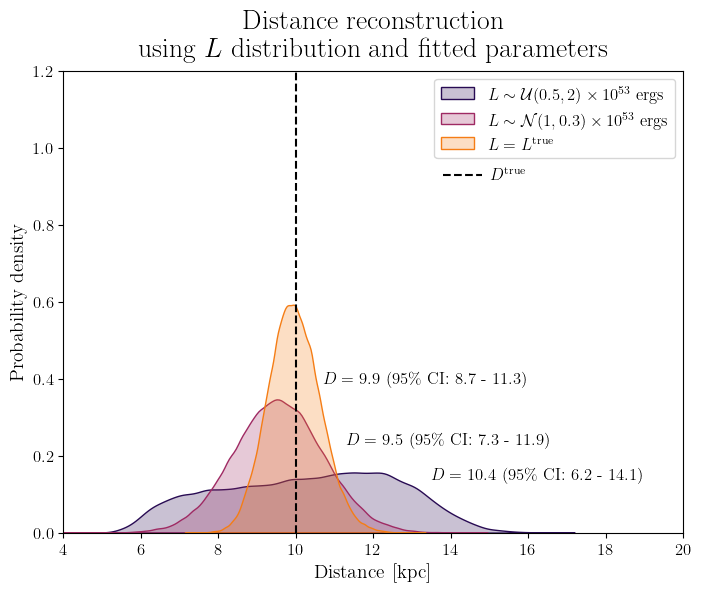

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
# plt.hist(distance, bins = [5 + i for i in range(40)], edgecolor = 'black', density = True)
sns.kdeplot(distance_large_uniform, fill = True, bw_adjust = 0.7, color = sns.color_palette('inferno')[0],
           label = r'$L \sim \mathcal{U}(0.5, 2) \times 10^{53}$ ergs')
sns.kdeplot(distance_tight_uniform, fill = True, bw_adjust = 0.7, color = sns.color_palette('inferno')[2],
           label = r'$L \sim \mathcal{N}(1, 0.3) \times 10^{53}$ ergs')
sns.kdeplot(distance_true, fill = True, bw_adjust = 0.7, color = sns.color_palette('inferno')[4],
           label = r'$L = L^{\mathrm{true}}$')
plt.axvline(10, ls = '--', color = 'black')
plt.xlim(4, 20)
plt.xlabel('Distance [kpc]', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylim(0, 1.2)
plt.ylabel('Probability density', fontsize = 14)
plt.yticks(fontsize = 12)
plt.legend(loc = 'upper right', fontsize = 12)
plt.hlines(0.93, 13.8, 14.8, ls = '--', color = 'black')
plt.text(15, 0.93, '$D^{\mathrm{true}}$', fontsize = 12, va = 'center')
plt.title('Distance reconstruction \n using $L$ distribution and fitted parameters',
          fontsize = 20, pad = 10)
plt.text(10.7, 0.4, '$D = $' + f' {np.median(distance_true):.1f} (95\% CI: {np.percentile(distance_true, 2.5):.1f} - {np.percentile(distance_true, 97.5):.1f})',
         fontsize = 12, va = 'center')
plt.text(11.3, 0.24, '$D = $' + f' {np.nanmedian(distance_tight_uniform):.1f} (95\% CI: {np.nanpercentile(distance_tight_uniform, 2.5):.1f} - {np.nanpercentile(distance_tight_uniform, 97.5):.1f})',
         fontsize = 12, va = 'center')
plt.text(13.5, 0.15, '$D = $' + f' {np.median(distance_large_uniform):.1f} (95\% CI: {np.percentile(distance_large_uniform, 2.5):.1f} - {np.percentile(distance_large_uniform, 97.5):.1f})',
         fontsize = 12, va = 'center')
# plt.savefig(f'Plots/Distance_reconstruction_DUNE_perfect_resolution_{EOS}_{hierarchy}.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'Plots/Distance_reconstruction_DUNE_perfect_resolution_{EOS}_{hierarchy}.svg',
#             dpi = 300, bbox_inches = 'tight')
plt.show()

In [337]:
parameters[f'True {hierarchy}']['Distance'] = 10
parameters[f'Fitted_delta_0 {hierarchy}']['Distance_mean'] = np.mean(distance_tight_uniform)
parameters[f'Fitted_delta_0 {hierarchy}']['Distance_median'] = np.median(distance_tight_uniform)
parameters[f'Fitted_delta_0 {hierarchy}']['Distance_IQR'] = [np.percentile(distance_tight_uniform, 25), np.percentile(distance_tight_uniform, 75)]
parameters[f'Fitted_delta_0 {hierarchy}']['Distance_95CI'] = [np.percentile(distance_tight_uniform, 2.5), np.percentile(distance_tight_uniform, 97.5)]

In [338]:
pd.DataFrame(parameters)

,True inverted,Fitted_delta_0 inverted
Alpha_best,1.748238,1.522258
Alpha_std,0.002561,0.140527
E_mean_best,12.626061,12.105343
E_mean_std,0.006393,0.380618
Distance,10.000000,NaN
Distance_mean,NaN,9.427002
Distance_median,NaN,9.449037
Distance_IQR,NaN,"[8.736871934059012, 10.147586672682628]"
Distance_95CI,NaN,"[7.2798467975736445, 11.441825769361422]"


In [362]:
for i in tqdm(range(2)):
    E = np.linspace(5, 100, 500) # Neutrino detection energy
    ref = dtc.energy_sampler(E, EOS, detector, hierarchy, 10,
                             theta_detec = 0, get_directions = False, perfect_resolution = True,
                            print_expected = False)
    y, bins = np.histogram(ref['Energy_Total'], bins = [3.5*i for i in range(29)], density = True)
    x = (bins[:-1] + bins[1:])/2
    
    c, cov = curve_fit(fitting_spectra, x, y, bounds = ([0,0],[5, 20]))
    
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}'] = {}
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Alpha_best'] = c[0]
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Alpha_std'] = np.sqrt(cov[0,0])
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['E_mean_best'] = c[1]
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['E_mean_std'] = np.sqrt(cov[1,1])
    
    N_T = len(ref['Energy_Total'])
    
    distance_N = []
    distance_U = []

    for j in range(50000):
        # Sampling neutron star mass
        m_ns = np.random.normal(1.33, 0.09)
        # Setting the radius
        radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
        # Calculating total luminosity
        # L = 3.6e53*((m_ns/1.5)**2)*(10/radius)*6.2415e5
        L2 = np.random.uniform(6e52, 3e53)*6.2415e5
        L = np.random.normal(1.5e53, 3e52)*6.2415e5
        L_eff = L*0.3
        L_eff2 = L2*0.3
        # Calculating distance squared
        a = np.random.normal(c[0], np.sqrt(cov[0,0]))
        b = np.random.normal(c[1], np.sqrt(cov[1,1]))
        D_square_N = (L_eff/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)*total_cross, x)
        D_square_U = (L_eff2/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)*total_cross, x)
        distance_N.append(np.sqrt(D_square_N)*3.2408e-22)
        distance_U.append(np.sqrt(D_square_U)*3.2408e-22)
        
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_mean_N'] = np.mean(distance_N)
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_median_N'] = np.median(distance_N)
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_IQR_N'] = [np.percentile(distance_N, 25), np.percentile(distance_N, 75)]
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_95CI_N'] = [np.percentile(distance_N, 2.5), np.percentile(distance_N, 97.5)]
    
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_mean_U'] = np.mean(distance_U)
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_median_U'] = np.median(distance_U)
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_IQR_U'] = [np.percentile(distance_U, 25), np.percentile(distance_U, 75)]
    parameters[f'Fitted_delta_0_run_{i}_{hierarchy}']['Distance_95CI_U'] = [np.percentile(distance_U, 2.5), np.percentile(distance_U, 97.5)]

100%|██████████| 2/2 [18:01<00:00, 540.69s/it]


In [363]:
pd.DataFrame(parameters)

,True inverted,Fitted_delta_0 inverted,Fitted_delta_0_run_0_inverted,Fitted_delta_0_run_1_inverted,Fitted_delta_0_run_2_inverted,Fitted_delta_0_run_3_inverted,Fitted_delta_0_run_4_inverted
Alpha_best,1.748238,1.522258,1.621631,1.842299,1.154695,1.727289,1.437927
Alpha_std,0.002561,0.140527,0.104897,0.220875,0.109946,0.092605,0.144853
E_mean_best,12.626061,12.105343,12.244035,12.734624,11.057227,12.718153,11.772456
E_mean_std,0.006393,0.380618,0.2721,0.530427,0.339612,0.23545,0.400708
Distance,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
Distance_mean,NaN,9.427002,NaN,NaN,NaN,NaN,NaN
Distance_median,NaN,9.449037,NaN,NaN,NaN,NaN,NaN
Distance_IQR,NaN,"[8.736871934059012, 10.147586672682628]",NaN,NaN,NaN,NaN,NaN
Distance_95CI,NaN,"[7.2798467975736445, 11.441825769361422]",NaN,NaN,NaN,NaN,NaN
Distance_mean_N,NaN,NaN,10.235388,NaN,10.374952,10.849481,10.378916
